In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal 
lal.swig_redirect_standard_output_error(True)

import numpy as np
from test_model_wvfm import LnLikelihoodWvfm, LnPriorUniformWvfm
from impulse.base import PTTestSampler

import matplotlib.pyplot as plt
from tqdm import tqdm
import corner

from impulse.ptsampler import PTState

from emcee.autocorr import integrated_time, function_1d

In [47]:
lnlike = LnLikelihoodWvfm('test_cbc_inj.ini')

inj_pars = lnlike.injection.injection_parameters.copy()
mass_1 = inj_pars['mass_1']
mass_2 = inj_pars['mass_2']
chi1 = inj_pars['chi_1']
chi2 = inj_pars['chi_2']

mtotal = mass_1 + mass_2
q = mass_1 / mass_2
eta = q / (1.0+q)**2
mchirp = mtotal * eta**(3.0/5.0)

lnprior = LnPriorUniformWvfm(
    [mchirp-20, 0.05, -1.0, -1.0], 
    [mchirp+20, 0.25, 1.0, 1.0]
    )

/Users/jthompson/miniconda3/envs/wdm/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)
12:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
12:48 bilby INFO    : Injected signal in E1:
12:48 bilby INFO    :   optimal SNR = 8147.19
12:48 bilby INFO    :   matched filter SNR = 8147.19-0.00j
12:48 bilby INFO    :   mass_1 = 250.0
12:48 bilby INFO    :   mass_2 = 75.0
12:48 bilby INFO    :   chi_1 = 0.3
12:48 bilby INFO    :   chi_2 = 0.2
12:48 bilby INFO    :   theta_jn = 0.0
12:48 bilby INFO    :   ra = -2.084056769166123
12:48 bilby INFO    :   dec = 0.8107952638302021
12:48 bilby INFO    :   geocent_time = 1198775939.8912647
12:48 bilby INFO    :   phase = 0.0
12:48 bilby INFO    :   psi = 0.0


In [48]:
ntemps = lnlike.ntemps
nsamples = lnlike.nsamples
sampler = PTTestSampler(4, lnlike, lnprior, cov_update=100, ntemps=ntemps, swap_steps=10, inf_temp=True)

In [49]:
sampler.sample(np.array([105.0, 0.1, 0.0, 0.2]), lnlike.nsamples, thin=1)

100%|██████████| 10000/10000 [04:36<00:00, 36.14it/s]


In [50]:
chains = []
for ii in range(ntemps):
    with open(f'/Users/jthompson/git/impulse/examples/chains/chain_{ii}.txt') as fp:
        chains.append(np.loadtxt(fp))

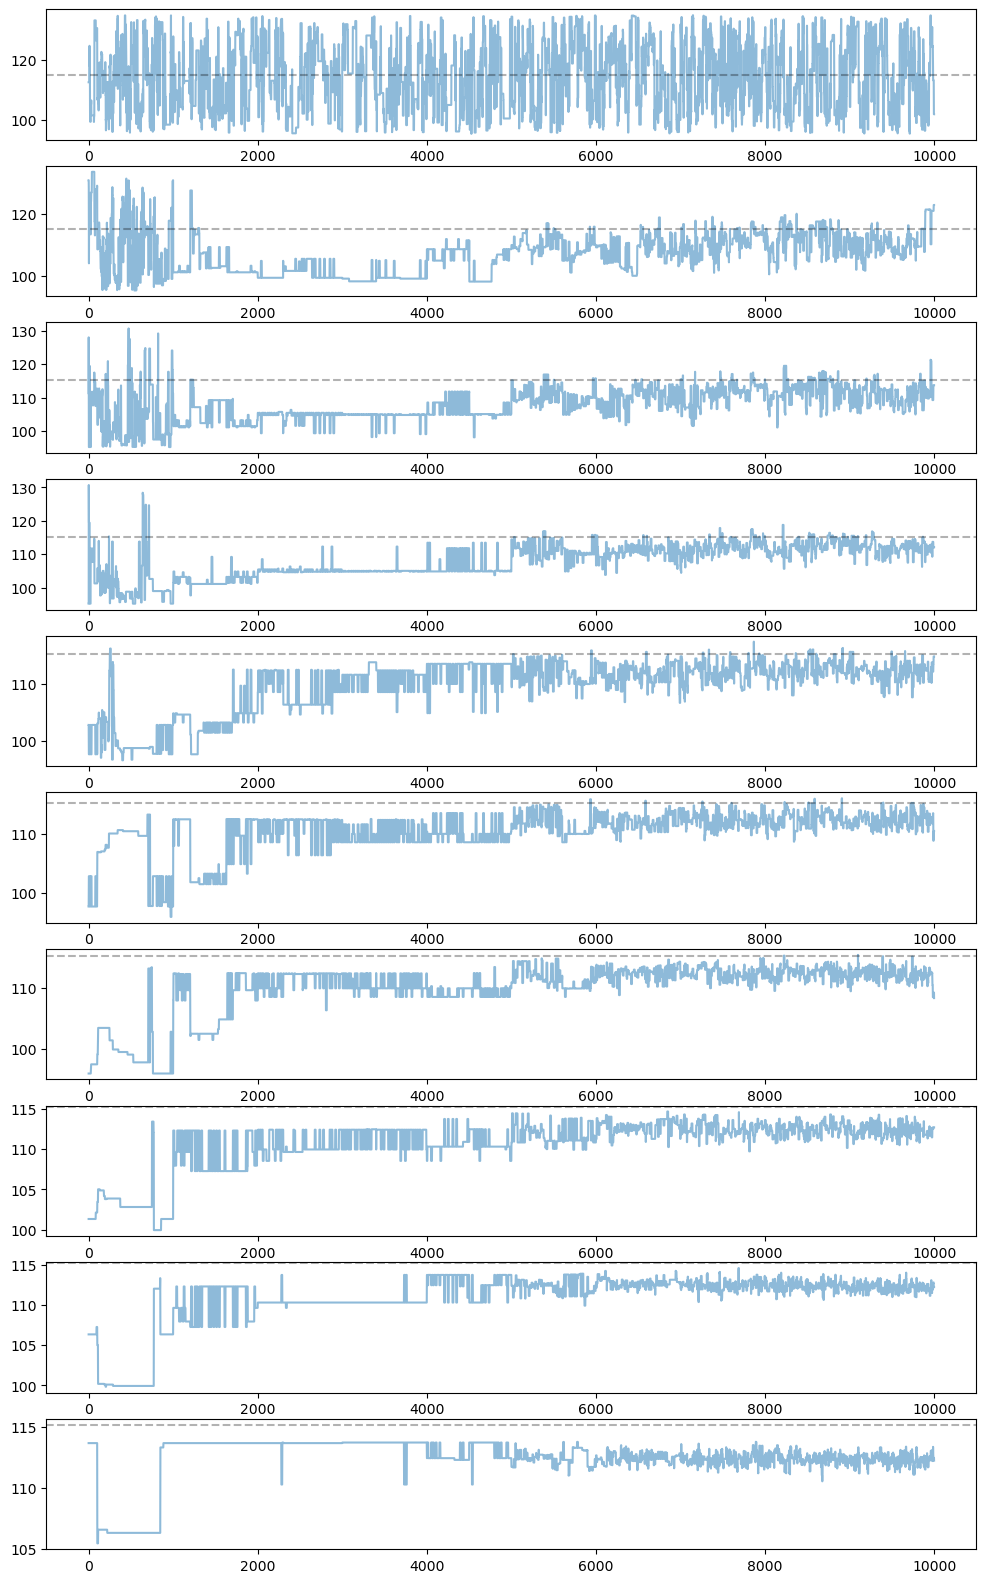

In [51]:
fig, axs = plt.subplots(ncols=1, nrows = len(chains), figsize=(12,ntemps*2))
for i, ax in zip(range(len(chains)), axs):

    ax.plot(chains[len(chains) - i - 1][:, 0], alpha = 0.5)
    ax.axhline(y=mchirp,ls='--',alpha=0.3, c='k')
    # ax.plot(chains[len(chains) - i - 1][:, 1], alpha = 0.5)
    # ax.axhline(y=eta,ls='--',alpha=0.3, c='k')
    # ax.set_ylim(-1.1,1.1)

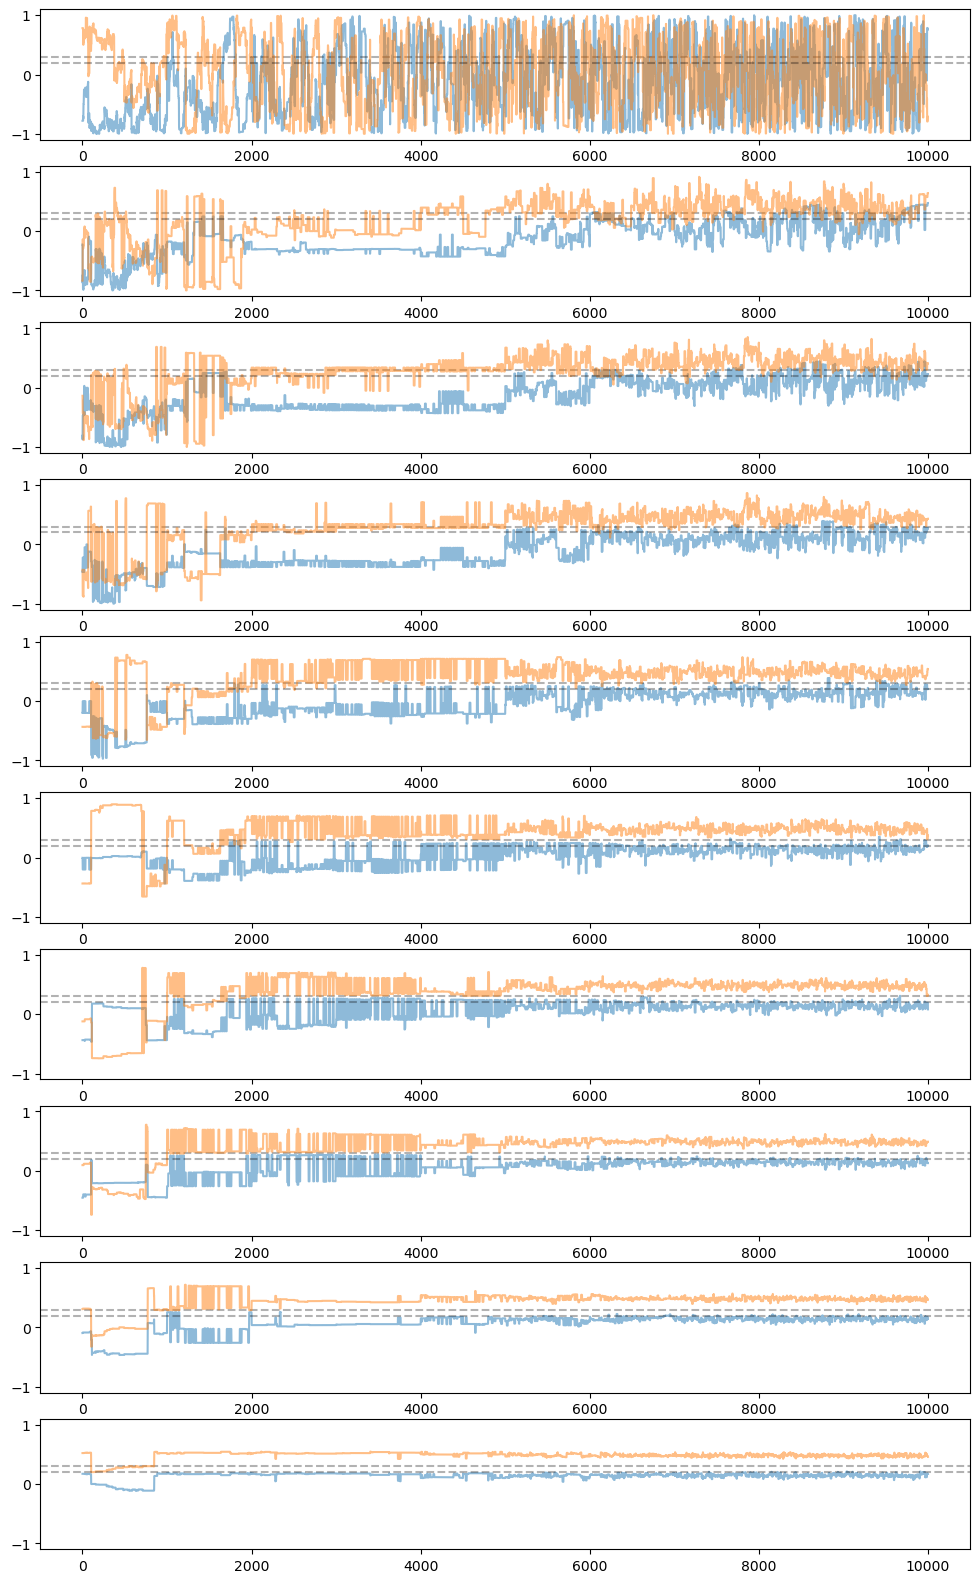

In [52]:
fig, axs = plt.subplots(ncols=1, nrows = len(chains), figsize=(12,ntemps*2))
for i, ax in zip(range(len(chains)), axs):

    ax.plot(chains[len(chains) - i - 1][:, 2], alpha = 0.5)
    ax.axhline(y=chi1,ls='--',alpha=0.3, c='k')
    ax.plot(chains[len(chains) - i - 1][:, 3], alpha = 0.5)
    ax.axhline(y=chi2,ls='--',alpha=0.3, c='k')
    ax.set_ylim(-1.1,1.1)

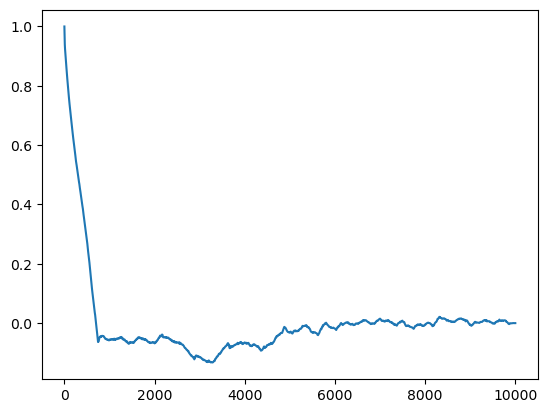

In [53]:
plt.plot(function_1d(chains[0][:,3]))
plt.show()

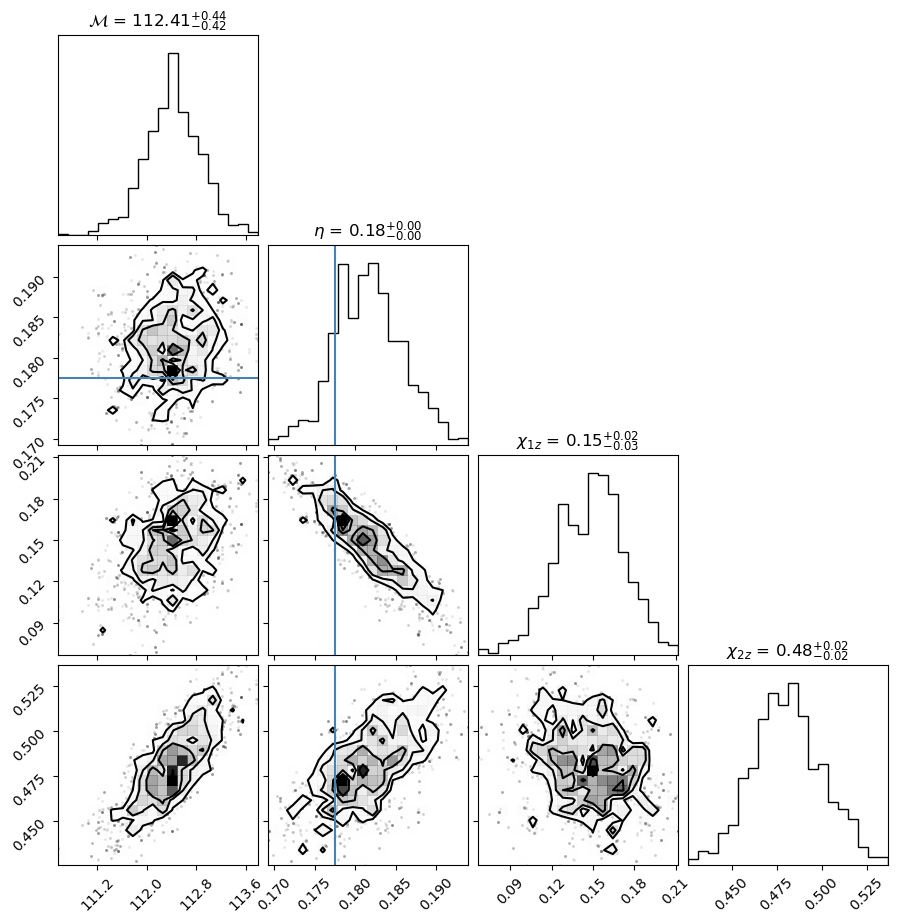

In [57]:
burn = 6000

corner.corner(chains[0][burn::1, :4], truths=[mchirp, eta, chi1, chi2],
              titles=[r'$\mathcal{M}$', r'$\eta$', r'$\chi_{1z}$', r'$\chi_{2z}$'], show_titles=True)
plt.show()